In [5]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def gaussian_kernel(kernel_size, sigma):
    """
    2D 가우시안 커널 생성 함수.
    - kernel_size: 커널 크기 (홀수)
    - sigma: 가우시안 분포의 표준편차
    """
    if kernel_size % 2 == 0:
        raise ValueError("kernel_size must be an odd number.")
    ax = np.linspace(-(kernel_size - 1) / 2, (kernel_size - 1) / 2, kernel_size)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))
    kernel /= np.sum(kernel)
    return kernel

def gaussian_kernel_1d(kernel_size, sigma):
    """
    1D 가우시안 커널 생성 함수.
    - kernel_size: 커널 길이 (홀수)
    - sigma: 가우시안 분포의 표준편차
    """
    if kernel_size % 2 == 0:
        raise ValueError("kernel_size must be an odd number.")
    ax = np.linspace(-(kernel_size - 1) / 2, (kernel_size - 1) / 2, kernel_size)
    kernel = np.exp(-0.5 * (ax / sigma)**2)
    kernel /= np.sum(kernel)
    return kernel

def pad_image_cv2(img, pad_h, pad_w, border_type=cv2.BORDER_CONSTANT, value=0):
    """
    OpenCV의 copyMakeBorder 함수를 이용해 이미지에 패딩을 적용합니다.
    
    Parameters:
      - img: 입력 이미지 (numpy array)
      - pad_h: 위, 아래 패딩 크기
      - pad_w: 좌, 우 패딩 크기
      - border_type: 패딩 방식 (cv2.BORDER_CONSTANT, cv2.BORDER_REPLICATE, 
                     cv2.BORDER_REFLECT, cv2.BORDER_WRAP, cv2.BORDER_REFLECT_101)
      - value: BORDER_CONSTANT일 때 사용할 상수 값
    """
    padded = cv2.copyMakeBorder(img, pad_h, pad_h, pad_w, pad_w,
                                borderType=border_type, value=value)
    return padded

def convolve2d(image, kernel, border_type=cv2.BORDER_CONSTANT, value=0):
    """
    일반적인 2D 컨볼루션을 수행하는 함수.
    
    Parameters:
      - image: 2D 그레이스케일 이미지 (numpy array)
      - kernel: 2D 컨볼루션 커널
      - border_type, value: 패딩 옵션
    """
    H, W = image.shape
    kH, kW = kernel.shape
    pad_h = kH // 2
    pad_w = kW // 2
    padded_image = pad_image_cv2(image, pad_h, pad_w, border_type, value)
    output = np.zeros((H, W), dtype=np.float64)
    kernel_flipped = np.flipud(np.fliplr(kernel))  # 컨볼루션 정의에 따른 커널 뒤집기

    for x in range(H):
        for y in range(W):
            region = padded_image[x:x+kH, y:y+kW]
            output[x, y] = np.sum(region * kernel_flipped)
    
    return output

def convolve1d(image, kernel, axis, border_type=cv2.BORDER_CONSTANT, value=0):
    """
    1D 컨볼루션을 수행하는 함수.
    
    Parameters:
      - image: 2D 그레이스케일 이미지
      - kernel: 1D 컨볼루션 커널
      - axis: 1이면 수평 방향, 0이면 수직 방향
      - border_type, value: 패딩 옵션
    """
    kernel_size = kernel.shape[0]
    pad = kernel_size // 2
    kernel_flipped = np.flip(kernel)  # 가우시안 커널은 대칭이지만, 컨볼루션 정의에 맞춰 뒤집습니다.
    
    if axis == 1:
        # 수평 방향: 좌우에만 패딩 적용
        padded = pad_image_cv2(image, 0, pad, border_type, value)
        H, W = image.shape
        output = np.zeros_like(image, dtype=np.float64)
        for i in range(H):
            for j in range(W):
                output[i, j] = np.sum(padded[i, j:j+kernel_size] * kernel_flipped)
    elif axis == 0:
        # 수직 방향: 상하에만 패딩 적용
        padded = pad_image_cv2(image, pad, 0, border_type, value)
        H, W = image.shape
        output = np.zeros_like(image, dtype=np.float64)
        for i in range(H):
            for j in range(W):
                output[i, j] = np.sum(padded[i:i+kernel_size, j] * kernel_flipped)
    else:
        raise ValueError("Axis must be 0 (vertical) or 1 (horizontal)")
    
    return output

def apply_gaussian_blur_separable(image, kernel_size, sigma, border_type=cv2.BORDER_CONSTANT, value=0):
    """
    1D 가우시안 필터 두 개를 이용해 separable하게 가우시안 블러를 적용하는 함수.
    
    Parameters:
      - image: 2D 그레이스케일 이미지
      - kernel_size: 커널 크기 (홀수)
      - sigma: 표준편차
      - border_type, value: 패딩 옵션
    """
    kernel_1d = gaussian_kernel_1d(kernel_size, sigma)
    # 수평 방향 컨볼루션
    intermediate = convolve1d(image, kernel_1d, axis=1, border_type=border_type, value=value)
    # 수직 방향 컨볼루션
    blurred = convolve1d(intermediate, kernel_1d, axis=0, border_type=border_type, value=value)
    return blurred

def apply_gaussian_blur(image, kernel_size, sigma, separable=True, border_type=cv2.BORDER_CONSTANT, value=0):
    """
    주어진 그레이스케일 이미지에 가우시안 블러를 적용하는 함수.
    
    Parameters:
      - image: 2D 그레이스케일 이미지 (numpy array)
      - kernel_size: 가우시안 커널 크기 (홀수)
      - sigma: 가우시안 분포의 표준편차
      - separable: Boolean 값. True이면 두 개의 1D 필터를 사용하여 separable 방식으로 처리,
                   False이면 2D 컨볼루션 방식으로 처리합니다.
      - border_type: 패딩 방식 (cv2.BORDER_CONSTANT, cv2.BORDER_REPLICATE, 
                     cv2.BORDER_REFLECT, cv2.BORDER_WRAP, cv2.BORDER_REFLECT_101)
      - value: BORDER_CONSTANT일 경우 사용할 상수 값
    """
    if separable:
        return apply_gaussian_blur_separable(image, kernel_size, sigma, border_type, value)
    else:
        kernel = gaussian_kernel(kernel_size, sigma)
        return convolve2d(image, kernel, border_type, value)

def apply_gaussian_blur_rgb(image, kernel_size, sigma, separable=True, border_type=cv2.BORDER_CONSTANT, value=0):
    """
    RGB 이미지에 대해 각 채널별로 가우시안 블러를 적용합니다.
    
    Parameters:
      - image: RGB 이미지 (numpy array, shape: H x W x 3)
      - kernel_size: 커널 크기 (홀수)
      - sigma: 가우시안 분포의 표준편차
      - separable: True이면 1D 필터를 두 번 사용, False이면 2D 컨볼루션 사용
      - border_type, value: 패딩 옵션
    """
    # 이미지가 3채널(RGB) 인지 확인
    if len(image.shape) == 3 and image.shape[2] == 3:
        channels = cv2.split(image)
        blurred_channels = []
        for channel in channels:
            blurred_channel = apply_gaussian_blur(channel, kernel_size, sigma, separable, border_type, value)
            blurred_channels.append(blurred_channel.astype(channel.dtype))
        return cv2.merge(blurred_channels)
    else:
        # 3채널이 아니면 그레이스케일 방식 적용
        return apply_gaussian_blur(image, kernel_size, sigma, separable, border_type, value)





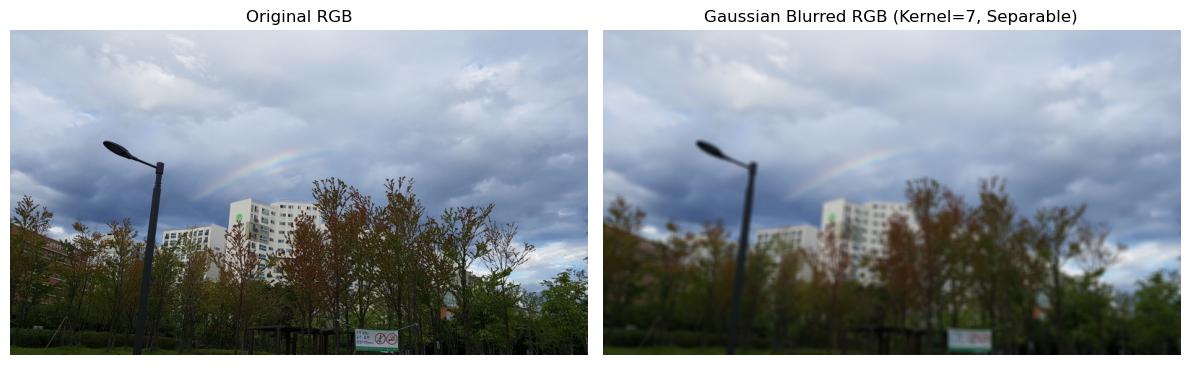

In [ ]:
if __name__ == "__main__":
    # 컬러 이미지를 로드 (cv2.imread는 BGR 순서로 읽으므로, RGB로 변환)
    image_bgr = cv2.imread("color1.jpg", cv2.IMREAD_COLOR)
    if image_bgr is None:
        print("이미지 'color1.jpg'를 불러올 수 없습니다.")
    else:
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        kernel_size = 7  # kernel size 7 사용 (홀수)
        sigma = 6.0      # sigma 값은 필요에 따라 조절
        separable = False 
        
        # separable=True 옵션으로 1D 필터 두 번 적용하여 블러 처리
        blurred_rgb = apply_gaussian_blur_rgb(image_rgb, kernel_size, sigma, separable, border_type=cv2.BORDER_REFLECT)
        
        
        title_text = f"Gaussian Blurred RGB (Kernel={kernel_size}, Separable={separable})"
         
        # 결과 시각화 (원본과 블러 처리된 이미지 비교)
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.title("Original RGB")
        plt.imshow(image_rgb)
        plt.axis("off")
        
        plt.subplot(1, 2, 2)
        plt.title(tile_text)
        plt.imshow(blurred_rgb)
        plt.axis("off")
        
        plt.tight_layout()
        plt.show()